In [1]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from qiskit import pulse

from twoqutritpulsesimulator import TwoQutritPulseSimulator
from processtomography import TwoQutritProcessTomography

## Defining some useful functions and making some instantiations

In [4]:
sim = TwoQutritPulseSimulator()
backend = sim.get_backend()

In [5]:
dchan0 = pulse.DriveChannel(0)
dchan1 = pulse.DriveChannel(1)

uchan0 = pulse.ControlChannel(0)
uchan1 = pulse.ControlChannel(1)

achan0 = pulse.AcquireChannel(0)
achan1 = pulse.AcquireChannel(1)

memslot0 = pulse.MemorySlot(0)
memslot1 = pulse.MemorySlot(1)

In [6]:
def get_cr01_pulse(amp):
    dur = Parameter('duration')
    with pulse.build(name="cr_01") as cr01_pulse:        
        pulse.set_frequency(freq_1, uchan0)
        pulse.play(pulse.GaussianSquare(dur, amp, 76, 0.9*dur, limit_amplitude=False), uchan0)
    return cr01_pulse

def get_cr12_pulse(amp):
    dur = Parameter('duration')
    with pulse.build(name="cr_12") as cr12_pulse:        
        pulse.set_frequency(ef_freq_1, uchan0)
        pulse.play(pulse.GaussianSquare(dur, amp, 76, 0.9*dur, limit_amplitude=False), uchan0)
    return cr12_pulse

In [7]:
def process_fidelity(chi_desired, chi_ideal):
    return np.trace(np.matmul(chi_desired, chi_ideal))/81

In [8]:
from qiskit import pulse
from simulator_parameters_2q import get_parameter
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector

freq_0 = get_parameter('freq', 0)
freq_1 = get_parameter('freq', 1)

ef_freq_0 = get_parameter('ef_freq', 0)
ef_freq_1 = get_parameter('ef_freq', 1)

In [9]:
qpt = TwoQutritProcessTomography(backend=backend)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.cm as cm


def compare_plot(ideal_chi_matrix, sim_chi_matrix):
    dim = 81
    chi_ideal = np.real(np.array(ideal_chi_matrix))
    chi_sim = np.real(np.array(sim_chi_matrix))

    if chi_ideal[0][0] > 5:
        print(f"The value of the (0,0) elements is {chi_ideal[0][0]} and is an outlier. Removing that point for better comparison")
        chi_ideal[0][0] = 0
        chi_sim[0][0] = 0
    
    # Plotting setup
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, facecolor='white')

    # Define VIBGYOR gradient colors
    vibgyor_colors = [
        '#0000FF',  # Blue
        '#FFFFFF',  # White
        '#FF0000'   # Red
    ]
    vibgyor_cmap = LinearSegmentedColormap.from_list("vibgyor", vibgyor_colors)

    # Range of color scale
    vmin = -max(chi_ideal.max(), chi_sim.max())
    vmax = max(chi_ideal.max(), chi_sim.max())

    # Plotting chi_theory
    im0 = axs[0].imshow(np.abs(chi_ideal), cmap=vibgyor_cmap, vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("Theory", fontsize=14)
    axs[0].tick_params(labelsize=10)

    # Plotting chi_sim
    im1 = axs[1].imshow(np.abs(chi_sim), cmap=vibgyor_cmap, vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("Simulation", fontsize=14)
    axs[1].tick_params(labelsize=10)

    # Adjust layout to make space for colorbar
    plt.subplots_adjust(right=0.85)

    # Correctly placed and labeled colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Pushed further right
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.set_label(r"$\chi_{ij}$", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # White figure background
    fig.patch.set_facecolor('white')

    display(plt.show())

# Realizing the proposed UCX01 gate

### Obtaining the process matrix of the ideal UCX01 gate

In [11]:
ideal_ucx01 = np.array(np.kron([[0,1,0],[1,0,0],[0,0,1j]], [[1,0,0],[0,0,0],[0,0,0]]) + np.kron([[1,0,0],[0,1,0],[0,0,1]], [[0,0,0],[0,1,0],[0,0,0]]) + np.kron([[0,1,0],[1,0,0],[0,0,-1j]], [[0,0,0],[0,0,0],[0,0,1]]), dtype='complex').copy()

In [12]:
process_matrix_ideal_ucx01 = qpt.run(gate=ideal_ucx01)

### Obtaining the process matrix of the simulated UCX01 gate

In [13]:
dt = 1/4.5e9

amplitude = 1.1
duration = 900

cr_pulse = get_cr01_pulse(amplitude)
cr_pulse.assign_parameters({'duration': int(duration)})
t_span = [0., cr_pulse.duration*dt]

state_array = []
for i in range(9):
    y0 = np.array([0,0,0,0,0,0,0,0,0])
    y0[i] = 1
    y0 = Statevector(y0)
    cr_job = backend.solve(cr_pulse, t_span=t_span, y0=y0)
    state_array.append(cr_job[0].y[-1].data)
state_array = np.array(state_array)
candidate_gate_ucx01 = state_array.transpose()

In [14]:
global_phase_ucx01 = 1/(candidate_gate_ucx01[0][3]/np.abs(candidate_gate_ucx01[0][3]))

In [15]:
theta = -np.pi/14
phase_gate_0 = np.array([[1, 0, 0],[0, np.cos(theta)+(1j*np.sin(theta)), 0],[0, 0, (1/np.sqrt(2))-(1j/np.sqrt(2))]])

In [16]:
phase_gate_1 = global_phase_ucx01*np.kron(np.eye(3), phase_gate_0)

In [17]:
sim_ucx01 = np.matmul(phase_gate_1, candidate_gate_ucx01)

In [18]:
process_matrix_sim_ucx01 = qpt.run(gate=sim_ucx01)

### Checking the fidelity of the simulated gate.

In [19]:
fid_ucx01 = process_fidelity(process_matrix_ideal_ucx01, process_matrix_sim_ucx01)
print(f"The fidelity of the simulated UCX01 gate is : {fid_ucx01}.")

The fidelity of the simulated UCX01 gate is : (0.9973447086171396+1.4802973661668753e-16j).


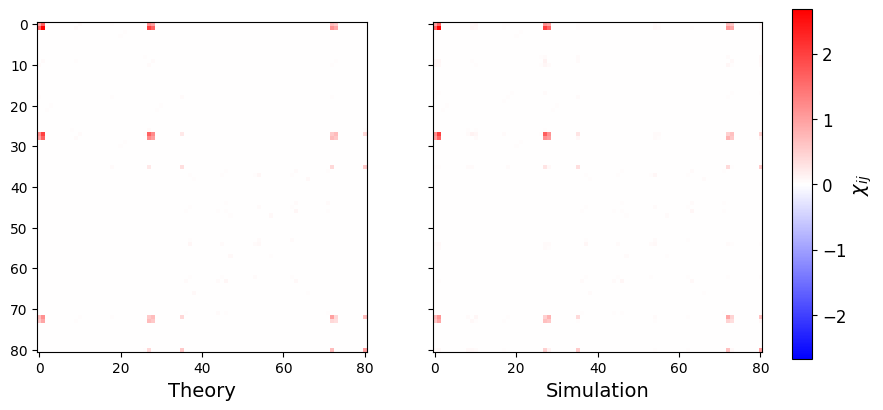

None

In [20]:
compare_plot(process_matrix_ideal_ucx01, process_matrix_sim_ucx01)

# Realizing the proposed UCX12 gate

### Obtaining the process matrix of the ideal UCX12 gate

In [21]:
ideal_ucx12 = np.array(np.kron([[1j,0,0],[0,0,1],[0,1,0]], [[1,0,0],[0,0,0],[0,0,0]]) + np.kron([[1,0,0],[0,1,0],[0,0,1]], [[0,0,0],[0,1,0],[0,0,0]]) + np.kron([[-1j,0,0],[0,0,1],[0,1,0]], [[0,0,0],[0,0,0],[0,0,1]]), dtype='complex').copy()

In [22]:
process_matrix_ideal_ucx12 = qpt.run(gate=ideal_ucx12)

### Obtaining the process matrix of the simulated UCX12 gate

In [23]:
dt = 1/4.5e9

amplitude = 0.4
duration = 900

cr_pulse = get_cr12_pulse(amplitude)
cr_pulse.assign_parameters({'duration': int(duration)})
t_span = [0., cr_pulse.duration*dt]

state_array = []
for i in range(9):
    y0 = np.array([0,0,0,0,0,0,0,0,0])
    y0[i] = 1
    y0 = Statevector(y0)
    cr_job = backend.solve(cr_pulse, t_span=t_span, y0=y0)
    state_array.append(cr_job[0].y[-1].data)
state_array = np.array(state_array)
candidate_gate_ucx12 = state_array.transpose()

In [24]:
global_phase_ucx12 = 1/(candidate_gate_ucx12[0][0]/np.abs(candidate_gate_ucx12[0][0]))
inter_gate_ucx12 = global_phase_ucx12*candidate_gate_ucx12

In [25]:
phase_0 = 1j
phase_1 = 1/(inter_gate_ucx12[1][1]/np.abs(inter_gate_ucx12[1][1]))
phase_2 = -1j/(inter_gate_ucx12[2][2]/np.abs(inter_gate_ucx12[2][2]))

phase_gate_0 = np.kron(np.eye(3), np.diag([phase_0, phase_1, phase_2]))

In [26]:
inter_gate_1_ucx12 = np.matmul(phase_gate_0, inter_gate_ucx12)

In [27]:
phase_0 = 1
phase_1 = 1/(inter_gate_1_ucx12[3][6]/np.abs(inter_gate_1_ucx12[3][6]))
phase_2 = 1/(inter_gate_1_ucx12[6][3]/np.abs(inter_gate_1_ucx12[6][3]))
phase_gate_1 = np.kron(np.diag([phase_0, phase_1, phase_2]), np.eye(3))

In [28]:
sim_ucx12 = np.matmul(phase_gate_1, inter_gate_1_ucx12)

In [29]:
process_matrix_sim_ucx12 = qpt.run(gate=sim_ucx12)

### Checking the fidelity of the simulated gate.

In [30]:
fid_ucx12 = process_fidelity(process_matrix_ideal_ucx12, process_matrix_sim_ucx12)
print(f"The fidelity of the simulated UCX12 gate is : {fid_ucx12}.")

The fidelity of the simulated UCX12 gate is : (0.9787832766832667-6.956026975274901e-17j).


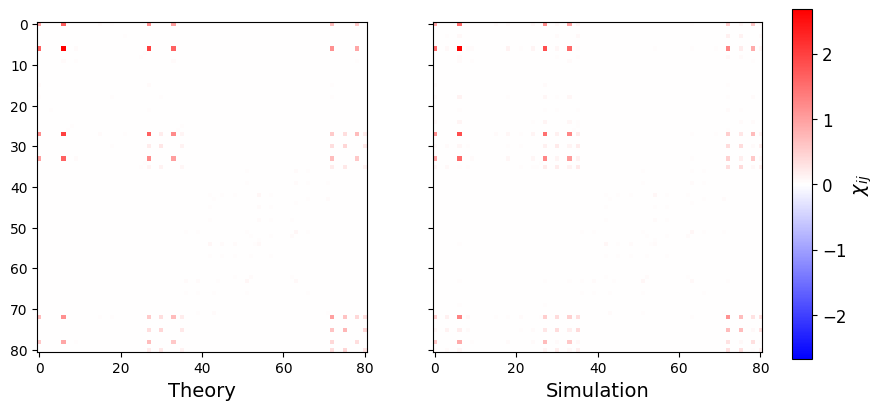

None

In [31]:
compare_plot(process_matrix_ideal_ucx12, process_matrix_sim_ucx12)

# Realizing the proposed UCH01 gate

### Obtaining the process matrix of the ideal UCH01 gate

In [32]:
ideal_uch01 = np.kron([[1/np.sqrt(2),1/np.sqrt(2),0],[-1/np.sqrt(2),1/np.sqrt(2),0],[0,0,1]], [[1,0,0],[0,0,0],[0,0,0]]) + np.kron([[1,0,0],[0,1,0],[0,0,1]], [[0,0,0],[0,1,0],[0,0,0]]) + np.kron([[1/np.sqrt(2),-1/np.sqrt(2),0],[1/np.sqrt(2),1/np.sqrt(2),0],[0,0,1]], [[0,0,0],[0,0,0],[0,0,1]])

In [33]:
process_matrix_ideal_uch01 = qpt.run(gate=ideal_uch01)

### Obtaining the process matrix of the simulated UCH01 gate

In [34]:
dt = 1/4.5e9

amplitude = 1.1
duration = 450
phase1 = np.pi/2


cr_pulse = get_cr01_pulse(amplitude)
cr_pulse.assign_parameters({'duration': int(duration)})
t_span = [0., cr_pulse.duration*dt]

with pulse.build() as phase_pulse:
    pulse.shift_phase(phase1, uchan0)

state_array = []
for i in range(9):
    y0 = np.array([0,0,0,0,0,0,0,0,0])
    y0[i] = 1
    y0 = Statevector(y0)
    cr_job = backend.solve(phase_pulse.append(cr_pulse), t_span=t_span, y0=y0)
    state_array.append(cr_job[0].y[-1].data)
state_array = np.array(state_array)
candidate_gate_uch01 = state_array.transpose()

In [35]:
phase_0 = 1/(candidate_gate_uch01[6][6]/np.abs(candidate_gate_uch01[6][6]))
phase_1 = 1/(candidate_gate_uch01[7][7]/np.abs(candidate_gate_uch01[7][7]))
phase_2 = 1/(candidate_gate_uch01[8][8]/np.abs(candidate_gate_uch01[8][8]))

phase_gate_0 = np.kron(np.eye(3), np.diag([phase_0, phase_1, phase_2]))

In [36]:
sim_uch01 = np.matmul(phase_gate_0, candidate_gate_uch01)

In [37]:
process_matrix_sim_uch01 = qpt.run(gate=sim_uch01)

### Checking the fidelity of the simulated gate.

In [38]:
fid_uch01 = process_fidelity(process_matrix_ideal_uch01, process_matrix_sim_uch01)
print(f"The fidelity of the simulated UCH01 gate is : {fid_uch01}.")

The fidelity of the simulated UCH01 gate is : (0.9939378134034041+1.02798428206033e-18j).


The value of the (0,0) elements is 6.801386896767571 and is an outlier. Removing that point for better comparison


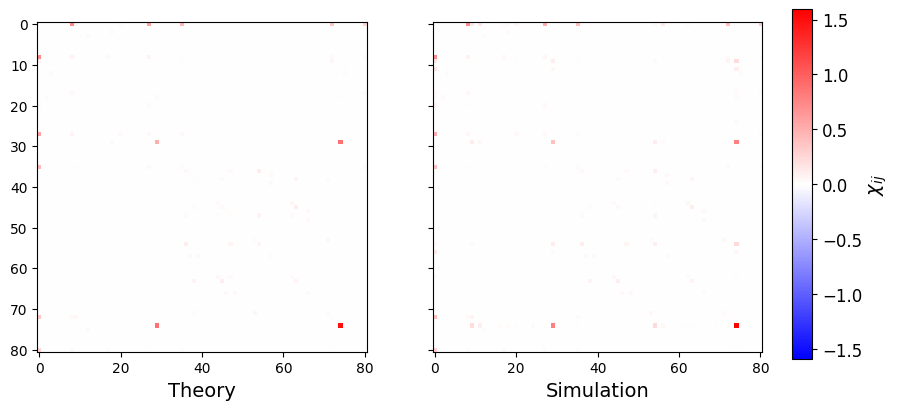

None

In [39]:
compare_plot(process_matrix_ideal_uch01, process_matrix_sim_uch01)

# Realizing the proposed UCH12 gate

### Obtaining the process matrix of the ideal UCH12 gate

In [40]:
ideal_uch12 = np.kron([[1,0,0],[0,1/np.sqrt(2),1/np.sqrt(2)],[0,-1/np.sqrt(2),1/np.sqrt(2)]], [[1,0,0],[0,0,0],[0,0,0]]) + np.kron([[1,0,0],[0,1,0],[0,0,1]], [[0,0,0],[0,1,0],[0,0,0]]) + np.kron([[1,0,0],[0,1/np.sqrt(2),-1/np.sqrt(2)],[0,1/np.sqrt(2),1/np.sqrt(2)]], [[0,0,0],[0,0,0],[0,0,1]])

In [41]:
process_matrix_ideal_uch12 = qpt.run(gate=ideal_uch12)

### Obtaining the process matrix of the simulated UCH12 gate

In [42]:
dt = 1/4.5e9

amplitude = 0.4
duration = 450

phase1 = 1.3615109172373014

cr_pulse = get_cr12_pulse(amplitude)
cr_pulse.assign_parameters({'duration': int(duration)})
t_span = [0., cr_pulse.duration*dt]

with pulse.build() as phase_pulse:
    pulse.shift_phase(phase1, uchan0)

state_array = []
for i in range(9):
    y0 = np.array([0,0,0,0,0,0,0,0,0])
    y0[i] = 1
    y0 = Statevector(y0)
    cr_job = backend.solve(phase_pulse.append(cr_pulse), t_span=t_span, y0=y0)
    state_array.append(cr_job[0].y[-1].data)
state_array = np.array(state_array)
candidate_gate_uch12 = state_array.transpose()

In [43]:
global_phase_uch12 = 1/(candidate_gate_uch12[1][1]/np.abs(candidate_gate_uch12[1][1]))
inter_gate_uch12 = global_phase_uch12*candidate_gate_uch12

In [44]:
phase_0 = 1/(inter_gate_uch12[0][0]/np.abs(inter_gate_uch12[0][0]))
phase_1 = 1
phase_2 = 1

phase_gate_0 = np.kron(np.eye(3), np.diag([phase_0, phase_1, phase_2]))

In [45]:
sim_uch12 = np.matmul(phase_gate_0, inter_gate_uch12)

In [46]:
process_matrix_sim_uch12 = qpt.run(gate=sim_uch12)

### Checking the fidelity of the simulated gate.

In [47]:
fid_uch12 = process_fidelity(process_matrix_ideal_uch12, process_matrix_sim_uch12)
print(f"The fidelity of the simulated UCH12 gate is : {fid_uch12}.")

The fidelity of the simulated UCH12 gate is : (0.9899019740407949+2.7841240972467275e-18j).


The value of the (0,0) elements is 6.801386896767571 and is an outlier. Removing that point for better comparison


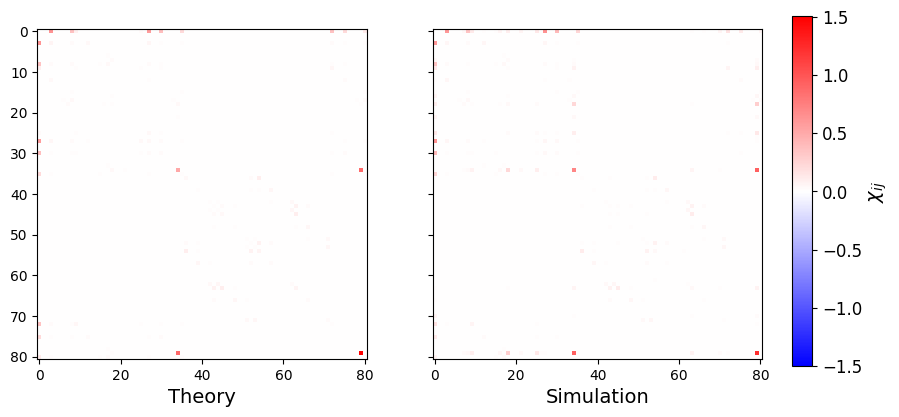

None

In [48]:
compare_plot(process_matrix_ideal_uch12, process_matrix_sim_uch12)